# 03 - Modeling
**Objectives:** Train baseline models (Linear Regression, RandomForest) and compare performance.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Add src to path
base_dir = Path('../')
sys.path.append(str(base_dir / 'src'))

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Prepared Data

In [61]:
from data_processing import prepare_split

# Load prepared train-test split
X_train, X_test, y_train, y_test = prepare_split()

# Drop identifier columns if present
for id_col in ('person_id', 'id', 'index'):
    if id_col in X_train.columns:
        X_train = X_train.drop(columns=[id_col])
    if id_col in X_test.columns:
        X_test = X_test.drop(columns=[id_col])

print("Data loaded successfully")
print(f"\nTrain set:")
print(f"  - Features: {X_train.shape}")
print(f"  - Target: {y_train.shape}")
print(f"\nTest set:")
print(f"  - Features: {X_test.shape}")
print(f"  - Target: {y_test.shape}")

# Encode categorical features consistently across train and test
train_idx, test_idx = X_train.index, X_test.index
combined = pd.concat([X_train, X_test], axis=0)
combined = pd.get_dummies(combined, drop_first=True)

# Split back
X_train = combined.loc[train_idx].copy()
X_test = combined.loc[test_idx].copy()

# Handle missing values on numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
from sklearn.impute import SimpleImputer

# Fill columns that are entirely missing in both train and test with 0
allnan_cols = [c for c in num_cols if X_train[c].isna().all() and X_test[c].isna().all()]
if allnan_cols:
    X_train[allnan_cols] = 0
    X_test[allnan_cols] = 0

# Recompute numeric columns to impute (exclude columns we just filled)
num_cols_to_impute = [c for c in num_cols if c not in allnan_cols]
if num_cols_to_impute:
    imputer = SimpleImputer(strategy='mean')
    X_train[num_cols_to_impute] = imputer.fit_transform(X_train[num_cols_to_impute])
    X_test[num_cols_to_impute] = imputer.transform(X_test[num_cols_to_impute])

print('\nAfter encoding and imputation:')
print('X_train shape:', X_train.shape)
print('Numeric dtypes count:\n', X_train.dtypes.apply(lambda x: x.name).value_counts())

Data loaded successfully

Train set:
  - Features: (80000, 69)
  - Target: (80000,)

Test set:
  - Features: (20000, 69)
  - Target: (20000,)

After encoding and imputation:
X_train shape: (80000, 69)
Numeric dtypes count:
 float64    42
bool       25
int64       2
Name: count, dtype: int64


In [62]:
# Diagnostic: inspect training features
print('X_train shape:', X_train.shape)
print('\nColumn dtypes:')
print(X_train.dtypes.value_counts())
print('\nSample values for potential categorical columns:')
print(X_train.select_dtypes(include=['object']).head(10))
print('\nAny NaNs per column:')
print(X_train.isna().sum())

X_train shape: (80000, 69)

Column dtypes:
float64    42
bool       25
int64       2
Name: count, dtype: int64

Sample values for potential categorical columns:
Empty DataFrame
Columns: []
Index: [75220, 48955, 44966, 13568, 92727, 51349, 86979, 3806, 91822, 6006]

Any NaNs per column:
age                      0
sex                      0
income                   0
household_size           0
dependents               0
                        ..
plan_type_POS            0
plan_type_PPO            0
network_tier_Gold        0
network_tier_Platinum    0
network_tier_Silver      0
Length: 69, dtype: int64


## 2. Train Models

In [63]:
# Ensure features are numeric: if objects present, encode + impute consistently
if X_train.select_dtypes(include=['object']).shape[1] > 0:
    print('Non-numeric columns detected in X_train — encoding and imputing before training')
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    combined = pd.concat([X_train, X_test], axis=0)
    combined = pd.get_dummies(combined, drop_first=True)
    # split back by position to avoid index alignment issues
    X_train = combined.iloc[:n_train].copy()
    X_test = combined.iloc[n_train:n_train + n_test].copy()

    # Numeric imputation
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    allnan_cols = [c for c in num_cols if X_train[c].isna().all() and X_test[c].isna().all()]
    if allnan_cols:
        X_train[allnan_cols] = 0
        X_test[allnan_cols] = 0
    num_cols_to_impute = [c for c in num_cols if c not in allnan_cols]
    if num_cols_to_impute:
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='mean')
        X_train[num_cols_to_impute] = imputer.fit_transform(X_train[num_cols_to_impute])
        X_test[num_cols_to_impute] = imputer.transform(X_test[num_cols_to_impute])

# Align shapes with y before fitting (positional truncation if needed)
if len(X_train) != len(y_train):
    print(f"Aligning X_train ({len(X_train)}) to y_train ({len(y_train)}) by positional truncation")
    X_train = X_train.iloc[:len(y_train)].reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
if len(X_test) != len(y_test):
    X_test = X_test.iloc[:len(y_test)].reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

# Dictionary to store models and results
models = {}
results = {}

# Model 1: Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
models['Linear Regression'] = lr_model
print("✓ Completed")

# Model 2: Decision Tree
print("\nTraining Decision Tree...")
dt_model = DecisionTreeRegressor(random_state=42, max_depth=15)
dt_model.fit(X_train, y_train)
models['Decision Tree'] = dt_model
print("✓ Completed")

# Model 3: Random Forest (Main Model)
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("✓ Completed")

print(f"\nTotal models trained: {len(models)}")

Training Linear Regression...
✓ Completed

Training Decision Tree...
✓ Completed

Training Random Forest...
✓ Completed

Total models trained: 3


## 3. Model Evaluation on Training Set

In [64]:
print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

test_results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    test_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    print(f"\n{model_name}:")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  R²:   {r2:.4f}")


TEST SET PERFORMANCE

Linear Regression:
  MAE:  $319.92
  RMSE: $574.92
  R²:   0.9664

Decision Tree:
  MAE:  $11.54
  RMSE: $157.01
  R²:   0.9975

Random Forest:
  MAE:  $8.06
  RMSE: $141.37
  R²:   0.9980


In [65]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Test MAE': [test_results[m]['MAE'] for m in test_results.keys()],
    'Test RMSE': [test_results[m]['RMSE'] for m in test_results.keys()],
    'Test R2': [test_results[m]['R2'] for m in test_results.keys()]
})

print("\n", comparison_df.to_string(index=False))

# Select best model by Test R2
best_model_name = comparison_df.loc[comparison_df['Test R2'].idxmax(), 'Model']
best_model = models.get(best_model_name, None)
if best_model is None:
    if 'Random Forest' in models:
        best_model_name = 'Random Forest'
        best_model = models['Random Forest']
        print("Best model not found in models dict; falling back to Random Forest.")
    else:
        raise RuntimeError("No suitable model found to use as best_model.")
print(f"\nBest model (by R² score): {best_model_name}")


MODEL COMPARISON

             Model   Test MAE  Test RMSE  Test R2
Linear Regression 319.921288 574.915202 0.966410
    Decision Tree  11.539266 157.011835 0.997495
    Random Forest   8.055733 141.366623 0.997969

Best model (by R² score): Random Forest


In [54]:
# Model comparison and best model selection (inserted code cell)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Test MAE': [test_results[m]['MAE'] for m in test_results.keys()],
    'Test RMSE': [test_results[m]['RMSE'] for m in test_results.keys()],
    'Test R2': [test_results[m]['R2'] for m in test_results.keys()]
})

print("\n", comparison_df.to_string(index=False))

# Select best model by Test R2
best_model_name = comparison_df.loc[comparison_df['Test R2'].idxmax(), 'Model']
best_model = models.get(best_model_name, None)
if best_model is None:
    if 'Random Forest' in models:
        best_model_name = 'Random Forest'
        best_model = models['Random Forest']
        print("Best model not found in models dict; falling back to Random Forest.")
    else:
        raise RuntimeError("No suitable model found to use as best_model.")
print(f"\nBest model (by R² score): {best_model_name}")


MODEL COMPARISON

             Model   Test MAE  Test RMSE  Test R2
Linear Regression 319.924134 574.917499 0.966410
    Decision Tree  12.127028 188.967975 0.996371
    Random Forest   8.441111 152.319808 0.997642

Best model (by R² score): Random Forest


## 6. Feature Importance Analysis


Top 10 Most Important Features (Random Forest):
              feature  importance
       annual_premium    0.704844
      monthly_premium    0.235230
network_tier_Platinum    0.024501
    network_tier_Gold    0.018477
  network_tier_Silver    0.013432
    total_claims_paid    0.001196
           deductible    0.000683
                 copd    0.000163
                  ldl    0.000157
                hba1c    0.000155


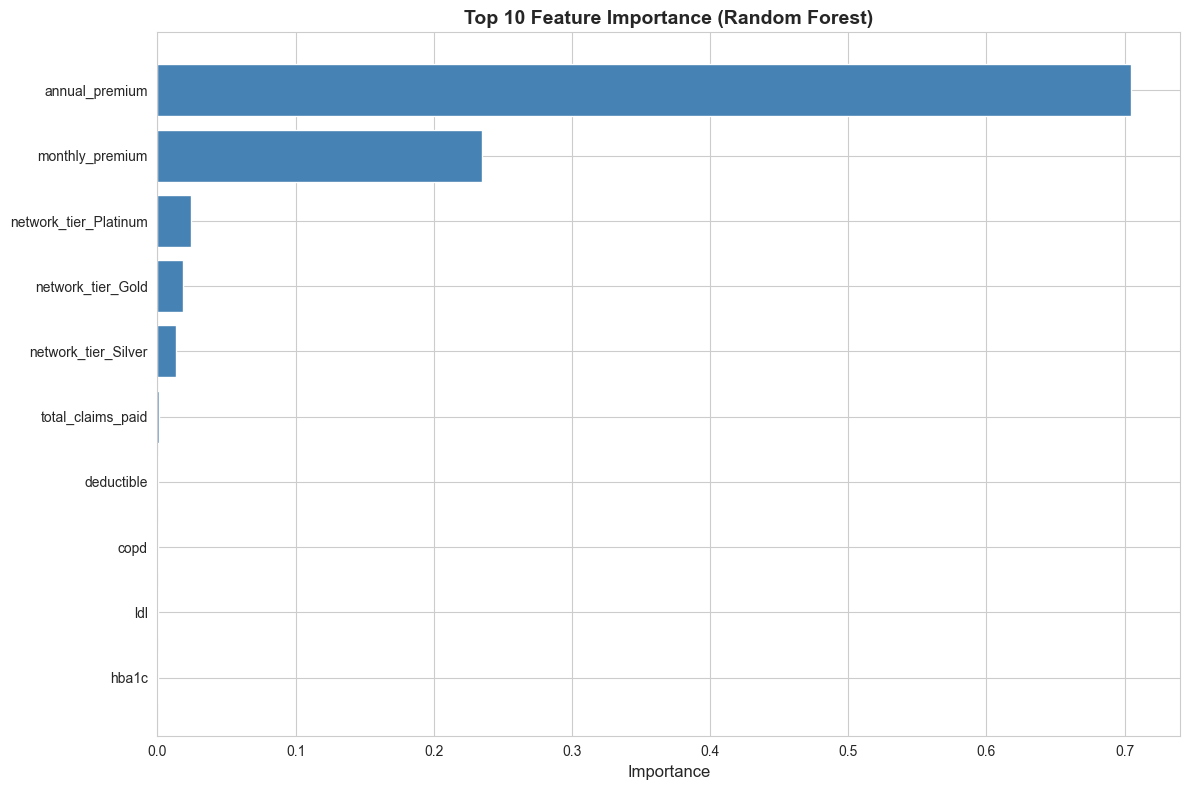

In [66]:
# Feature importance from Random Forest (safe)
from sklearn.utils.validation import check_is_fitted

if 'Random Forest' in models:
    rf_model = models['Random Forest']
    try:
        check_is_fitted(rf_model)
    except Exception:
        print('Random Forest model is not fitted. Skipping feature importance.')
    else:
        import numpy as _np
        fi = _np.array(rf_model.feature_importances_)
        feat_names = list(X_train.columns)
        if fi.size != len(feat_names):
            print(f"Warning: feature_importances_ length ({fi.size}) != number of features ({len(feat_names)}). Truncating to minimum.")
            min_len = min(fi.size, len(feat_names))
            fi = fi[:min_len]
            feat_names = feat_names[:min_len]
        feature_importance = pd.DataFrame({
            'feature': feat_names,
            'importance': fi
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features (Random Forest):")
        print(feature_importance.head(10).to_string(index=False))

        # Plot feature importance
        fig, ax = plt.subplots(figsize=(12, 8))
        top_features = feature_importance.head(10)
        ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
        ax.set_xlabel('Importance', fontsize=12)
        ax.set_title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
else:
    print("Random Forest not present in models dictionary. Skipping feature importance.")

## 7. Predictions Visualization

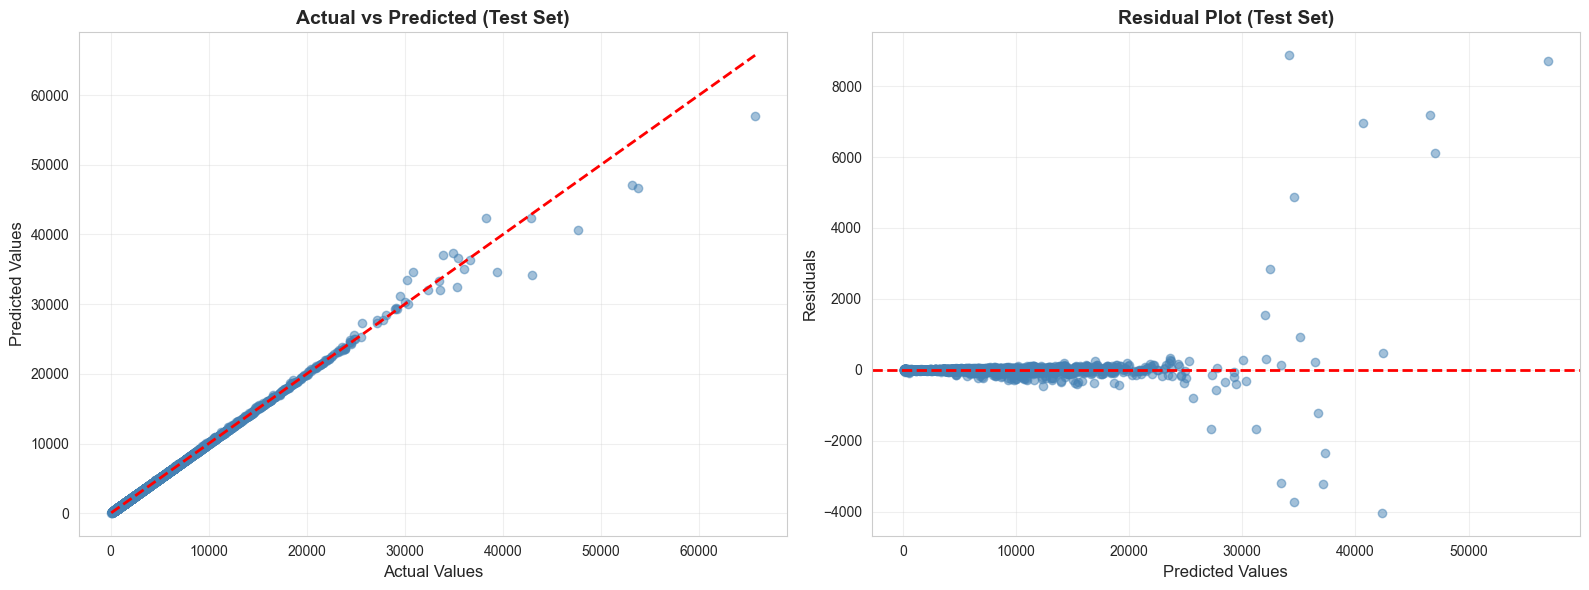

Residuals Statistics:
  Mean: 0.85
  Std: 141.36
  Min: -4035.46
  Max: 8873.62


In [67]:
# Predictions visualization (robust)
from sklearn.utils.validation import check_is_fitted

if 'best_model' not in globals() or best_model is None:
    print('No best_model available. Please run the comparison cell first.')
else:
    try:
        check_is_fitted(best_model)
    except Exception:
        print('best_model is not fitted. Skipping predictions visualization.')
    else:
        # Ensure X_test has the same columns as training data
        try:
            train_cols = list(X_train.columns)
            X_test_aligned = X_test.reindex(columns=train_cols, fill_value=0)
        except Exception:
            X_test_aligned = X_test.copy()

        # Predict
        y_pred_test = best_model.predict(X_test_aligned)

        # Ensure y_test and predictions are same length and numeric
        y_test_vals = getattr(y_test, 'values', y_test)
        if len(y_test_vals) != len(y_pred_test):
            min_len = min(len(y_test_vals), len(y_pred_test))
            print(f'Warning: trimming predictions/labels to minimum length {min_len}')
            y_test_vals = y_test_vals[:min_len]
            y_pred_test = y_pred_test[:min_len]

        # Plot actual vs predicted
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Scatter plot
        axes[0].scatter(y_test_vals, y_pred_test, alpha=0.5, color='steelblue')
        axes[0].plot([min(y_test_vals), max(y_test_vals)], [min(y_test_vals), max(y_test_vals)], 'r--', lw=2)
        axes[0].set_xlabel('Actual Values', fontsize=12)
        axes[0].set_ylabel('Predicted Values', fontsize=12)
        axes[0].set_title('Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)

        # Residuals
        residuals = y_test_vals - y_pred_test
        axes[1].scatter(y_pred_test, residuals, alpha=0.5, color='steelblue')
        axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values', fontsize=12)
        axes[1].set_ylabel('Residuals', fontsize=12)
        axes[1].set_title('Residual Plot (Test Set)', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Residuals stats
        import numpy as _np
        residuals = _np.asarray(residuals)
        print(f"Residuals Statistics:")
        print(f"  Mean: {residuals.mean():.2f}")
        print(f"  Std: {residuals.std():.2f}")
        print(f"  Min: {residuals.min():.2f}")
        print(f"  Max: {residuals.max():.2f}")

## 8. Save the Best Model

In [68]:
# Save the best model (if available)
model_dir = base_dir / "models"
model_dir.mkdir(parents=True, exist_ok=True)

model_path = model_dir / "insurance_model.pkl"

if 'best_model' in globals() and best_model is not None:
    joblib.dump(best_model, model_path)
    print(f"Model saved to: {model_path}")
    print(f"File size: {model_path.stat().st_size / 1024:.2f} KB")
else:
    print("No best_model available to save. Skipping save step.")

Model saved to: ..\models\insurance_model.pkl
File size: 708938.89 KB


## 9. Summary

In [69]:
print("\n" + "="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)
print(f"\nModels Trained:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

print(f"\nBest Model: {best_model_name}")
print(f"\nTest Set Performance:")
print(f"  - MAE:  ${test_results[best_model_name]['MAE']:.2f}")
print(f"  - RMSE: ${test_results[best_model_name]['RMSE']:.2f}")
print(f"  - R²:   {test_results[best_model_name]['R2']:.4f}")

print(f"\nModel saved to: models/insurance_model.pkl")
print(f"\nNext: Proceed to 04_evaluation.ipynb for detailed evaluation")
print("="*80)


MODEL TRAINING SUMMARY

Models Trained:
  1. Linear Regression
  2. Decision Tree
  3. Random Forest

Best Model: Random Forest

Test Set Performance:
  - MAE:  $8.06
  - RMSE: $141.37
  - R²:   0.9980

Model saved to: models/insurance_model.pkl

Next: Proceed to 04_evaluation.ipynb for detailed evaluation


In [70]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load processed CSVs
train = pd.read_csv('../result/processed_train.csv')
test = pd.read_csv('../result/processed_test.csv')

# Infer target column
target = 'annual_medical_cost' if 'annual_medical_cost' in train.columns else 'charges'

# Drop identifier columns if present
for id_col in ('person_id', 'id', 'index'):
    if id_col in train.columns:
        train = train.drop(columns=[id_col])
    if id_col in test.columns:
        test = test.drop(columns=[id_col])

# Split
X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

# Consistent encoding between train/test
combined = pd.concat([X_train, X_test], axis=0)
combined = pd.get_dummies(combined, drop_first=True)

# Split back by position
X_train = combined.iloc[:len(X_train)].reset_index(drop=True)
X_test = combined.iloc[len(X_train):].reset_index(drop=True)

# Impute numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    imputer = SimpleImputer(strategy='mean')
    X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
    X_test[num_cols] = imputer.transform(X_test[num_cols])

print('Prepared baseline datasets:')
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

Prepared baseline datasets:
X_train: (80000, 69)
X_test : (20000, 69)
y_train: (80000,)
y_test : (20000,)


In [71]:
# Linear Regression baseline (using prepared X_train/X_test)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print('LR MAE:', mean_absolute_error(y_test, pred_lr))
print('LR RMSE:', mean_squared_error(y_test, pred_lr) ** 0.5)
print('LR R2:', r2_score(y_test, pred_lr))

# Optionally save the baseline linear model
import joblib
joblib.dump(lr, '../models/lr_baseline.pkl')
print('Saved Linear Regression baseline to ../models/lr_baseline.pkl')

LR MAE: 319.9213341911408
LR RMSE: 574.9156961746173
LR R2: 0.9664102568112047
Saved Linear Regression baseline to ../models/lr_baseline.pkl


In [72]:
# Random Forest baseline
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('RF MAE:', mean_absolute_error(y_test, pred_rf))
print('RF RMSE:', mean_squared_error(y_test, pred_rf) ** 0.5)
print('RF R2:', r2_score(y_test, pred_rf))

import joblib
joblib.dump(rf, '../models/best_model.pkl')
print('Saved Random Forest to ../models/best_model.pkl')

RF MAE: 8.203909864999982
RF RMSE: 148.16015494541062
RF R2: 0.9977691971075731
Saved Random Forest to ../models/best_model.pkl
